In [310]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import sparse_encode
from pathlib import Path
import pandas as pd
import plotly.express as px
from numpy.lib.stride_tricks import sliding_window_view
from scipy.signal import fftconvolve, oaconvolve
from tqdm import tqdm

In [397]:
class KSVD:
    def __init__(self, n_nonzero_coefs, K, sparse_coding_solver='omp', max_iter=100, tol=1e-5, **args):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.K = K
        self.max_iter = max_iter
        self.tol = tol
        self.sparse_coding_solver = sparse_coding_solver
    
    def update_column(self, D, Z, X, k):
        z_row = Z[k]
        d_col = D[:, k]
        D_r = np.delete(D, k, axis=1)
        mask_nonzero = z_row != 0.
        if not mask_nonzero.any():
            return d_col, z_row
        Z_r = np.delete(Z[:, mask_nonzero], k, axis=0)
        rank_one_sum =  (D_r[:, None, :] * Z_r.T[None, :, :]).sum(axis=-1)
        E_r = X[:, mask_nonzero] - rank_one_sum
        U, Sigma, Vh = np.linalg.svd(E_r)
        d_col = U[:, 0]
        z_row[mask_nonzero] = Sigma[0] * Vh[:, 0]
        return d_col, z_row
    
    def fit(self, X):
        N = X.shape[0]

        D = np.random.randn(N, self.K)
        D = D / np.linalg.norm(D, axis=0, keepdims=True)

        prev_D = 0.

        for _ in tqdm(range(self.max_iter)):
            Z = sparse_encode(X.T, D.T, n_nonzero_coefs=self.n_nonzero_coefs, algorithm=self.sparse_coding_solver).T

            for k in range(D.shape[1]):
                D[:, k], Z[k] = self.update_column(D, Z, X, k)
            update_error = ((D - prev_D) ** 2).mean()
            if update_error <= self.tol:
                break
        self.D = D
        Z = sparse_encode(X.T, self.D.T, n_nonzero_coefs=self.n_nonzero_coefs, algorithm=self.sparse_coding_solver).T
        return D, Z
    
    def predict(self, X):
        Z = sparse_encode(X.T, self.D.T, n_nonzero_coefs=self.n_nonzero_coefs, algorithm=self.sparse_coding_solver).T
        return self.D @ Z


In [380]:
signal.shape

(1000,)

In [462]:
def reconstruct_signal(X_mat, signal_length, jump=1):
    N_window = X_mat.shape[0]
    z = np.eye(signal_length, signal_length - N_window + 1)[:, ::jump]
    X_shift = oaconvolve(X_mat, z, mode="full", axes=0)[:signal_length]
    ind_convolve = oaconvolve(np.ones_like(X_mat), z, mode="full", axes=0)[:signal_length]
    X_shift[np.abs(X_shift) < 1e-10] = 0.
    ind_convolve[ind_convolve < 1e-1] = 0.

    X_sum = X_shift.sum(axis=1)
    coefs = (ind_convolve != 0.).sum(axis=1)
    X_sum = X_sum / np.maximum(coefs, 1.)
    return X_sum

In [30]:
def get_trajectory_matrix(arr, window_shape, jump=1):
    return sliding_window_view(x=arr, window_shape=window_shape)[::jump].T

In [2]:
data_path = Path("./data/")
generation_data = data_path / "Plant_1_Generation_Data.csv"

In [3]:
df_generation = pd.read_csv(generation_data, index_col='DATE_TIME')

In [4]:
df_dc_power = df_generation[df_generation.SOURCE_KEY == "1BY6WEcLGh8j5v7"]

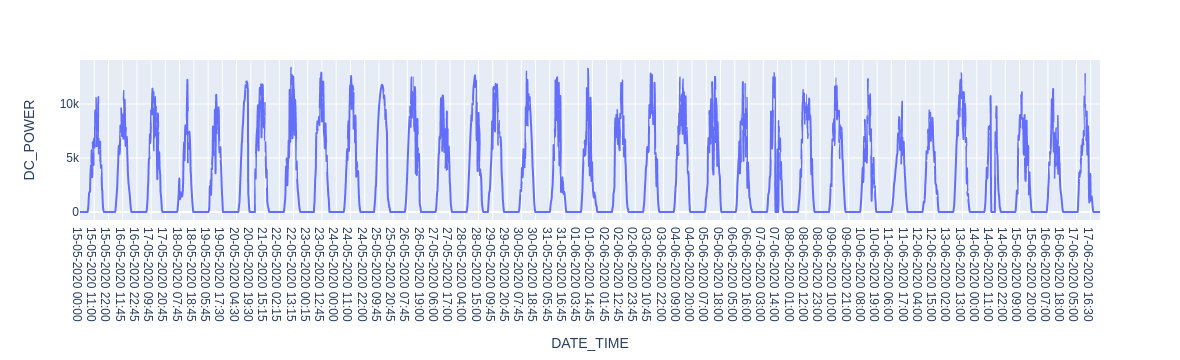

In [5]:
px.line(df_dc_power, x=df_dc_power.index, y='DC_POWER')

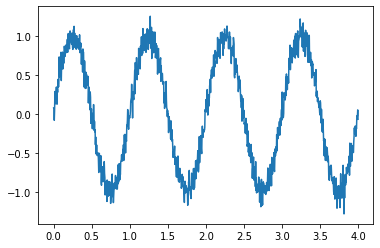

In [342]:
x = np.linspace(0, 4, 1000)
signal = np.sin(2 * np.pi * x)
sigma = .1
measure = signal + sigma * np.random.randn(x.shape[0])
X = get_trajectory_matrix(measure, 200)
plt.plot(x, measure)

In [358]:
ksvd = KSVD(n_nonzero_coefs=10, K=200, max_iter=10)

D, Z = ksvd.fit(X)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.36s/it]


In [359]:
X_reconstructed = ksvd.predict(X)

In [372]:
pred = reconstruct_signal(X_reconstructed, measure.shape[0])

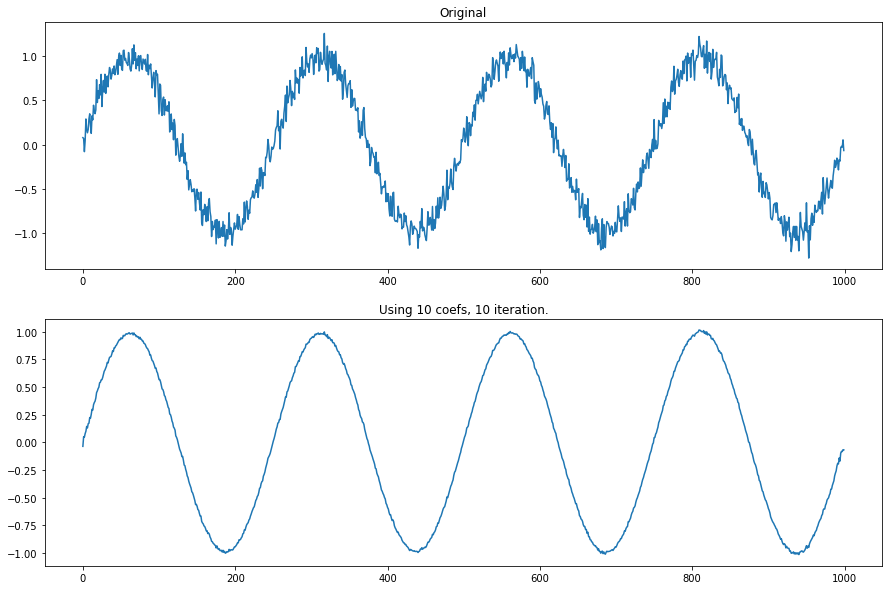

In [398]:
def plot_real_pred(signal, pred, n_coefs, n_iter):
    fig, ax = plt.subplots(2, 1, figsize=(15, 10))
    ax[0].plot(signal)
    ax[1].plot(pred)
    ax[0].set_title('Original')
    ax[1].set_title(f"Using {n_coefs} coefs, {n_iter} iteration.")

plot_real_pred(measure, pred, 10, 10)


In [316]:
dc_power = df_dc_power.DC_POWER.to_numpy()

In [455]:
X_power = get_trajectory_matrix(dc_power, 400, jump=10)

In [479]:
ksvd = KSVD(n_nonzero_coefs=10, K=1000, max_iter=5)
D, Z = ksvd.fit(X_power)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.56s/it]


In [480]:
dc_reconstructed= reconstruct_signal(ksvd.predict(X_power), signal_length=dc_power.shape[0], jump=10)

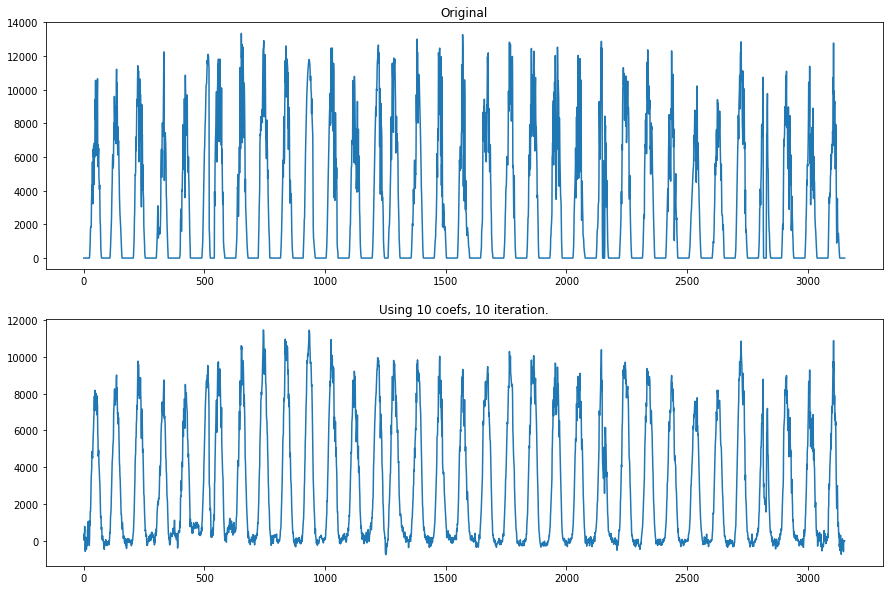

In [481]:
plot_real_pred(dc_power, dc_reconstructed, 10, 10)

In [484]:
def plot_atoms(D, Z, figsize=(25, 10), n_rows=2):
    n_use = (Z != 0).sum(axis=1)
    ind_use_sort = np.argsort(n_use)[::-1]
    
    D_plot = D[:, ind_use_sort[:3 * n_rows]]
    
    fig, axs = plt.subplots(n_rows, 3, figsize=figsize)
    
    n_plot = 0
    for i in range(n_rows):
        for j in range(3):
            ax = axs[i, j]
            ax.plot(D_plot[:, n_plot])
            n_plot += 1
    
    plt.show()
    return D_plot
    

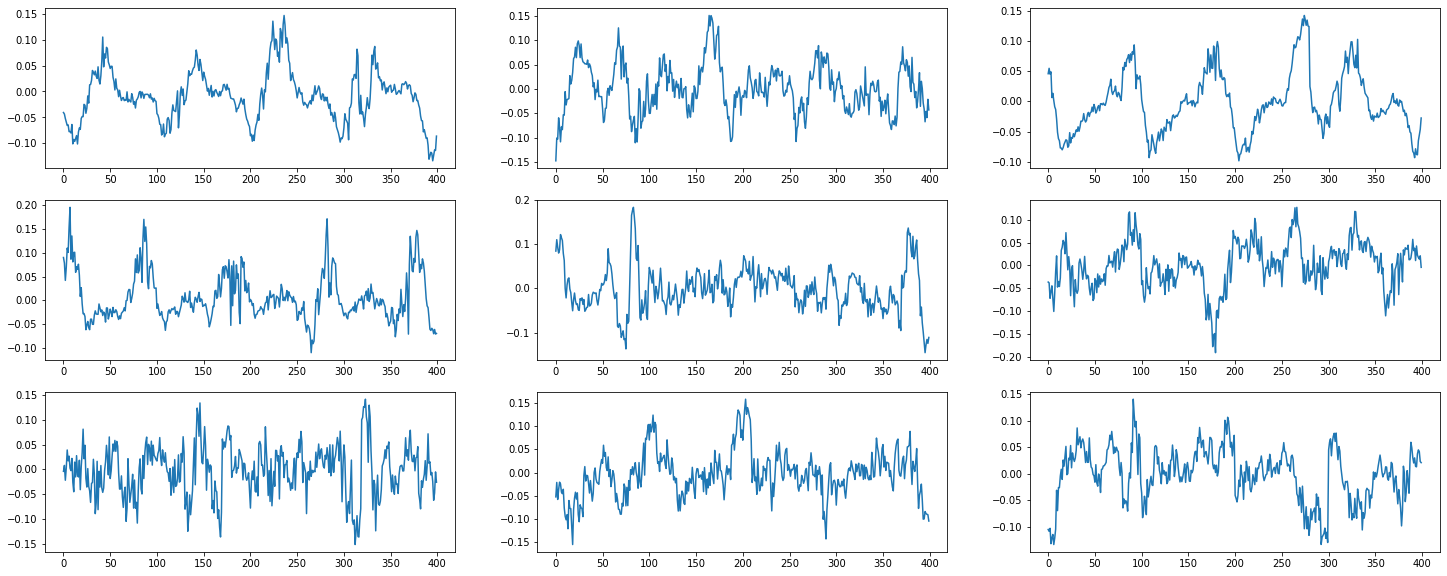

In [485]:
D_plot = plot_atoms(D, Z, n_rows=3)

In [434]:
D_plot[:, 

(400, 9)